# Preparação de Dados




In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE, SelectKBest, chi2, f_classif
from sklearn.linear_model import LogisticRegression

from google.colab import drive
drive.mount('/content/drive')

PATH_DRIVE_BIG_DATA = "/content/drive/MyDrive/MachineLearning/"

df = pd.read_csv(PATH_DRIVE_BIG_DATA + 'Focos_2020-01-01_2020-12-31.csv')

df.drop(['pais', 'satelite', 'latitude', 'longitude', 'municipio'], axis=1, inplace=True)

medianDiaSemChuva = df['diasemchuva'].median()
df['diasemchuva'].fillna(medianDiaSemChuva, inplace=True)
df['diasemchuva'] = df['diasemchuva'].apply(lambda item: 0.0 if item < 0 else item)

medianPrecipitacao = df['precipitacao'].median()
df['precipitacao'].fillna(medianPrecipitacao, inplace=True)
df['precipitacao'] = df['precipitacao'].apply(lambda item: 200.0 if item > 200 else item)

medianFRP = df['frp'].median()
df['frp'].fillna(medianFRP, inplace=True)
df['frp'] = df['frp'].apply(lambda item: 8000.0 if item > 8000 else item)

medianRiscoFogo = df['riscofogo'].median()
medianRiscoFogoByBioma = df.groupby('bioma')['riscofogo'].median()

for i in df.index:
  if pd.isnull(df.at[i, 'riscofogo']):
    df.at[i, 'riscofogo'] = medianRiscoFogo if pd.isnull(df.at[i, 'bioma']) else medianRiscoFogoByBioma[df.at[i, 'bioma']]

df['riscofogo'] = df['riscofogo'].apply(lambda item: 0.0 if item < 0 else item)


max_diasemchuva = df['diasemchuva'].max()
max_precipitacao = df['precipitacao'].max()
max_frp = df['frp'].max()

min_diasemchuva = df['diasemchuva'].min()
min_precipitacao = df['precipitacao'].min()
min_frp = df['frp'].min()

df['diasemchuva'] = df['diasemchuva'].apply(lambda item: (item - min_diasemchuva) / (max_diasemchuva - min_diasemchuva))
df['precipitacao'] = df['precipitacao'].apply(lambda item: (item - min_precipitacao) / (max_precipitacao - min_precipitacao))
df['frp'] = df['frp'].apply(lambda item: (item - min_frp) / (max_frp - min_frp))

df['mes'] = pd.to_datetime(df['datahora']).dt.month

df.drop(['datahora'], axis=1, inplace=True)

# Transformar o atributo qualitativo 'bioma' em dummies
df = pd.get_dummies(df, columns=['estado', 'bioma'], prefix=['E', 'B'])


Mounted at /content/drive


In [ ]:
# separar atributos e classe
dfCleanRange = df.drop(['riscofogo'], axis=1)
target = df['riscofogo']

X_train, X_test, y_train, y_test = train_test_split(dfCleanRange, target, test_size=0.3, random_state=88, stratify=target)

y_train_categories = y_train.apply(lambda item: 0 if item < 0.5 else 1)
y_test_categories = y_test.apply(lambda item: 0 if item < 0.5 else 1)

WIDTH = 400

def generateColumnsRFE(X_train, y_train, step, n):
  model = LogisticRegression()
  selected = RFE(model, step=step, n_features_to_select=n).fit(X_train, y_train)

  return X_train.columns[selected.get_support(indices=True)]

columnsRFE10 = generateColumnsRFE(X_train.head(WIDTH), y_train_categories.head(WIDTH), 1, 10)

X_train_RFE10, X_test_RFE10 = X_train[columnsRFE10], X_test[columnsRFE10]

columnsRFE5 = generateColumnsRFE(X_train.head(WIDTH), y_train_categories.head(WIDTH), 1, 5)

X_train_RFE5, X_test_RFE5 = X_train[columnsRFE5], X_test[columnsRFE5]


def generateColumnsSb(X_train, y_train, k):
  return SelectKBest(chi2, k=k).fit(X_train, y_train).get_feature_names_out()

columnsSB12 = generateColumnsSb(X_train, y_train_categories, 12)

X_trainsSB12, X_testSB12 = X_train[columnsSB12], X_test[columnsSB12]

columnsSB6 = generateColumnsSb(X_train, y_train_categories, 6)

X_trainsSB6, X_testSB6 = X_train[columnsSB6], X_test[columnsSB6]

print(f'Base 10 rfe: {columnsRFE10}')
print(f'Base 5 rfe: {columnsRFE5}')
print(f'Base 12 skb: {columnsSB12}')
print(f'Base 6 skb: {columnsSB6}')

Base 10 rfe: Index(['diasemchuva', 'precipitacao', 'E_AMAPA', 'E_MATO GROSSO DO SUL',
       'E_MINAS GERAIS', 'E_PARANA', 'E_RORAIMA', 'E_SANTA CATARINA',
       'B_Amazonia', 'B_Cerrado'],
      dtype='object')
Base 5 rfe: Index(['diasemchuva', 'precipitacao', 'E_MATO GROSSO DO SUL',
       'E_SANTA CATARINA', 'B_Amazonia'],
      dtype='object')
Base 12 skb: ['diasemchuva' 'precipitacao' 'E_ACRE' 'E_AMAZONAS' 'E_MINAS GERAIS'
 'E_PIAUI' 'E_RIO GRANDE DO SUL' 'E_SANTA CATARINA' 'B_Amazonia'
 'B_Caatinga' 'B_Cerrado' 'B_Pantanal']
Base 6 skb: ['diasemchuva' 'E_ACRE' 'E_AMAZONAS' 'B_Amazonia' 'B_Caatinga' 'B_Cerrado']


In [ ]:
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train_categories)

X_train_rus['riscofogo'] = target

X_train_rus

,diasemchuva,precipitacao,frp,mes,E_ACRE,E_ALAGOAS,E_AMAPA,E_AMAZONAS,E_BAHIA,E_CEARA,...,E_SAO PAULO,E_SERGIPE,E_TOCANTINS,B_Amazonia,B_Caatinga,B_Cerrado,B_Mata Atlantica,B_Pampa,B_Pantanal,riscofogo
0,0.016667,0.000000,0.000937,9,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1.0
1,0.000000,0.000797,0.021075,9,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0.9
2,0.016667,0.055777,0.002175,11,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0.8
3,0.058333,0.000000,0.001937,6,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1.0
4,0.025000,0.000797,0.001875,12,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78459,0.708333,0.000000,0.002100,8,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1.0
78460,0.008333,0.004781,0.006488,10,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0.9
78461,0.025000,0.000000,0.001025,11,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0.8
78462,0.816667,0.000000,0.011850,9,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0.7


In [ ]:
from google.colab import files
X_train_rus.to_csv('incendios_processado.csv', index=False)
files.download('incendios_processado.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Modelagem

In [1]:
# Importar bibliotecas necessárias
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score

model_lr = LogisticRegression()
model_lr.fit(X_train_RFE10, y_train_categories)
pred_lr = model_lr.predict(X_test_RFE10)

acc_lr = accuracy_score(y_test_categories, pred_lr)

print("Acurácia Regressão Logística RFE10:", acc_lr)

model_lr = LogisticRegression()
model_lr.fit(X_train_RFE5, y_train_categories)
pred_lr = model_lr.predict(X_test_RFE5)

acc_lr = accuracy_score(y_test_categories, pred_lr)
print("Acurácia Regressão Logística RFE5:", acc_lr)

model_lr = LogisticRegression()
model_lr.fit(X_trainsSB12, y_train_categories)
pred_lr = model_lr.predict(X_testSB12)

acc_lr = accuracy_score(y_test_categories, pred_lr)

print("Acurácia Regressão Logística SB12:", acc_lr)

model_lr = LogisticRegression()
model_lr.fit(X_trainsSB6, y_train_categories)
pred_lr = model_lr.predict(X_testSB6)

acc_lr = accuracy_score(y_test_categories, pred_lr)
print("Acurácia Regressão Logística SB6:", acc_lr)






model_lr = DecisionTreeClassifier()
model_lr.fit(X_train_RFE10, y_train_categories)
pred_lr = model_lr.predict(X_test_RFE10)

acc_lr = accuracy_score(y_test_categories, pred_lr)

print("Acurácia Árvore de Decisão RF10:", acc_lr)

model_lr = DecisionTreeClassifier()
model_lr.fit(X_train_RFE5, y_train_categories)
pred_lr = model_lr.predict(X_test_RFE5)

acc_lr = accuracy_score(y_test_categories, pred_lr)
print("Acurácia Árvore de Decisão RF5:", acc_lr)

model_lr = DecisionTreeClassifier()
model_lr.fit(X_trainsSB12, y_train_categories)
pred_lr = model_lr.predict(X_testSB12)

acc_lr = accuracy_score(y_test_categories, pred_lr)
acc_lrBest = acc_lr
print("Acurácia Árvore de Decisão SB12:", acc_lr)

model_lr = DecisionTreeClassifier()
model_lr.fit(X_trainsSB6, y_train_categories)
pred_lr = model_lr.predict(X_testSB6)

acc_lr = accuracy_score(y_test_categories, pred_lr)
print("Acurácia Árvore de Decisão SB6:", acc_lr)






model_lr = MLPClassifier()
model_lr.fit(X_train_RFE10, y_train_categories)
pred_lr = model_lr.predict(X_test_RFE10)

acc_lr = accuracy_score(y_test_categories, pred_lr)

print("Acurácia MLPClassifier RF10:", acc_lr)

model_lr = MLPClassifier()
model_lr.fit(X_train_RFE5, y_train_categories)
pred_lr = model_lr.predict(X_test_RFE5)

acc_lr = accuracy_score(y_test_categories, pred_lr)
print("Acurácia MLPClassifier RF5:", acc_lr)

model_lr = MLPClassifier()
model_lr.fit(X_trainsSB12, y_train_categories)
pred_lr = model_lr.predict(X_testSB12)

acc_lr = accuracy_score(y_test_categories, pred_lr)

print("Acurácia MLPClassifier SB12:", acc_lr)

model_lr = MLPClassifier()
model_lr.fit(X_trainsSB6, y_train_categories)
pred_lr = model_lr.predict(X_testSB6)

acc_lr = accuracy_score(y_test_categories, pred_lr)
print("Acurácia MLPClassifier SB6:", acc_lr)




model_lr = GaussianNB()
model_lr.fit(X_train_RFE10, y_train_categories)
pred_lr = model_lr.predict(X_test_RFE10)

acc_lr = accuracy_score(y_test_categories, pred_lr)

print("Acurácia GaussianNB RF10:", acc_lr)

model_lr = GaussianNB()
model_lr.fit(X_train_RFE5, y_train_categories)
pred_lr = model_lr.predict(X_test_RFE5)

acc_lr = accuracy_score(y_test_categories, pred_lr)
print("Acurácia GaussianNB RF5:", acc_lr)

model_lr = GaussianNB()
model_lr.fit(X_trainsSB12, y_train_categories)
pred_lr = model_lr.predict(X_testSB12)

acc_lr = accuracy_score(y_test_categories, pred_lr)

print("Acurácia GaussianNB SB12:", acc_lr)

model_lr = GaussianNB()
model_lr.fit(X_trainsSB6, y_train_categories)
pred_lr = model_lr.predict(X_testSB6)

acc_lr = accuracy_score(y_test_categories, pred_lr)
print("Acurácia GaussianNB SB6:", acc_lr)


print("Melhor acurácia SB12:", acc_lrBest)

NameError: name 'X_train_RFE10' is not defined

In [ ]:
params = {
    'criterion':('gini', 'entropy', 'log_loss'),
    'max_depth':[3, 5, 7, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = DecisionTreeClassifier(random_state=88)
gs = GridSearchCV(rf, params, cv=5)
gs.fit(X_trainsSB12, y_train_categories)
print('Melhores hiperparâmetros para DecisionTreeClassifier:', gs.best_params_)


# Avaliação de Modelo

In [ ]:
columnsSB34 = generateColumnsSb(X_train, y_train_categories, 34)

X_trainsSB34, X_testSB34 = X_train[columnsSB34], X_test[columnsSB34]

columnsSB24 = generateColumnsSb(X_train, y_train_categories, 24)

X_trainsSB24, X_testSB24 = X_train[columnsSB24], X_test[columnsSB24]


Classificação

##**DecisionTree**#

In [ ]:
from sklearn.tree import DecisionTreeClassifier

Acurácia

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
model_lr = DecisionTreeClassifier()
model_lr.fit(X_trainsSB34, y_train_categories)
pred_lrDTSB34 = model_lr.predict(X_testSB34)

acc_lrDTSB34 = accuracy_score(y_test_categories, pred_lrDTSB34)

print("Acurácia Arvore de Descisão sb34:", acc_lrDTSB34)

model_lr = DecisionTreeClassifier()
model_lr.fit(X_trainsSB24, y_train_categories)
pred_lrDTSB24 = model_lr.predict(X_testSB24)

acc_lrDTSB24 = accuracy_score(y_test_categories, pred_lrDTSB24)

print("Acurácia Arvore de Decisão sb24:", acc_lrDTSB24)

model_lr = DecisionTreeClassifier()
model_lr.fit(X_trainsSB12, y_train_categories)
pred_lrDTSB12 = model_lr.predict(X_testSB12)

acc_lrDTSB12 = accuracy_score(y_test_categories, pred_lrDTSB12)

print("Acurácia Arvore de Decisão sb12:", acc_lrDTSB12)

Acurácia Arvore de Descisão sb34: 0.8627468581687612
Acurácia Arvore de Decisão sb24: 0.8670406941950928
Acurácia Arvore de Decisão sb12: 0.8619838420107719


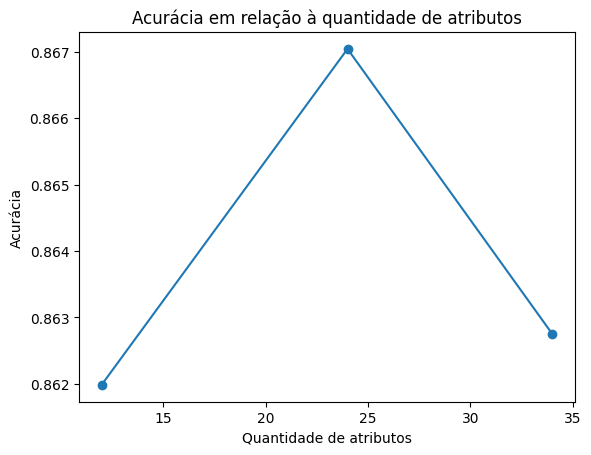

In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score


metrics = []
num_attributes = []

metrics.append(acc_lrDTSB34)
num_attributes.append(len(X_trainsSB34.columns))

metrics.append(acc_lrDTSB24)
num_attributes.append(len(X_trainsSB24.columns))

metrics.append(acc_lrDTSB12)
num_attributes.append(len(X_trainsSB12.columns))

plt.plot(num_attributes, metrics, marker='o')
plt.xlabel('Quantidade de atributos')
plt.ylabel('Acurácia')
plt.title('Acurácia em relação à quantidade de atributos')
plt.show()

Matriz de Confusão

In [ ]:
from  sklearn.metrics import confusion_matrix

34 colunas

In [ ]:
mc = confusion_matrix(y_test_categories, pred_lrDTSB34)

# mostrar um DF
df_mc = pd.DataFrame(mc, columns=['Predito 0', 'Predito 1'], index=['Real 0', 'Real 1'])

df_mc

,Predito 0,Predito 1
Real 0,12216,4598
Real 1,4576,45450


24 colunas

In [ ]:
mc = confusion_matrix(y_test_categories, pred_lrDTSB24)

# mostrar um DF
df_mc = pd.DataFrame(mc, columns=['Predito 0', 'Predito 1'], index=['Real 0', 'Real 1'])

df_mc

,Predito 0,Predito 1
Real 0,11941,4873
Real 1,4014,46012


12 colunas

In [ ]:
mc = confusion_matrix(y_test_categories, pred_lrDTSB12)

# mostrar um DF
df_mc = pd.DataFrame(mc, columns=['Predito 0', 'Predito 1'], index=['Real 0', 'Real 1'])

df_mc

,Predito 0,Predito 1
Real 0,11770,5044
Real 1,4181,45845


Especificidade e Sensibilidade

In [ ]:
from  sklearn.metrics import recall_score

# sensibilidade = recall para a categoria 1
sDTSB34 = recall_score(y_test_categories, pred_lrDTSB34, pos_label=1)

# especificidade = recall para a categoria 0
eDTSB34 = recall_score(y_test_categories, pred_lrDTSB34, pos_label=0)

print("Sensibilidade SB34", sDTSB34)
print("Especificidade SB34", eDTSB34)

# sensibilidade = recall para a categoria 1
sDTSB24 = recall_score(y_test_categories, pred_lrDTSB24, pos_label=1)

# especificidade = recall para a categoria 0
eDTSB24 = recall_score(y_test_categories, pred_lrDTSB24, pos_label=0)

print("Sensibilidade SB24", sDTSB24)
print("Especificidade SB24", eDTSB24)

# sensibilidade = recall para a categoria 1
sDTSB12 = recall_score(y_test_categories, pred_lrDTSB12, pos_label=1)

# especificidade = recall para a categoria 0
eDTSB12 = recall_score(y_test_categories, pred_lrDTSB12, pos_label=0)

print("Sensibilidade SB12", sDTSB12)
print("Especificidade SB12", eDTSB12)

Sensibilidade SB34 0.9085275656658538
Especificidade SB34 0.7265374093017724
Sensibilidade SB24 0.9197617239035701
Especificidade SB24 0.7101819911978113
Sensibilidade SB12 0.9164234598009036
Especificidade SB12 0.7000118948495302


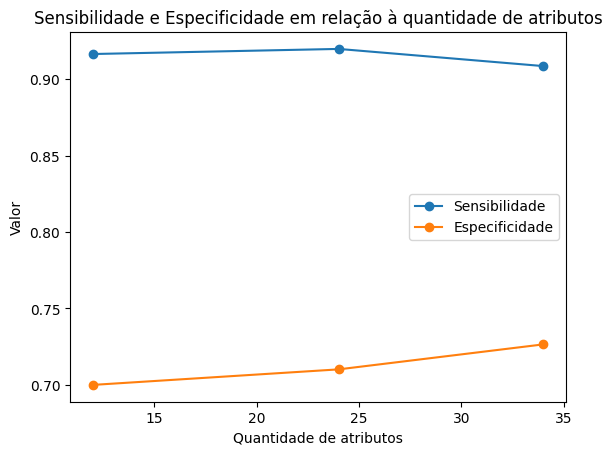

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score

sensitivity = []
specificity = []
num_attributes = []

# SB34
sensitivity.append(sDTSB34)
specificity.append(eDTSB34)
num_attributes.append(len(X_trainsSB34.columns))

# SB24
sensitivity.append(sDTSB24)
specificity.append(eDTSB24)
num_attributes.append(len(X_trainsSB24.columns))

# SB12
sensitivity.append(sDTSB12)
specificity.append(eDTSB12)
num_attributes.append(len(X_trainsSB12.columns))

plt.plot(num_attributes, sensitivity, marker='o', label='Sensibilidade')
plt.plot(num_attributes, specificity, marker='o', label='Especificidade')
plt.xlabel('Quantidade de atributos')
plt.ylabel('Valor')
plt.title('Sensibilidade e Especificidade em relação à quantidade de atributos')
plt.legend()
plt.show()

Precisão e Revocação

In [ ]:
from  sklearn.metrics import precision_recall_fscore_support
prDTSB34 = precision_recall_fscore_support(y_test_categories, pred_lrDTSB34)

print('Precisão SB34: ', prDTSB34[0])
print('Revocação SB34: ', prDTSB34[1])

prDTSB24 = precision_recall_fscore_support(y_test_categories, pred_lrDTSB24)

print('Precisão SB24: ', prDTSB24[0])
print('Revocação SB24: ', prDTSB24[1])

prDTSB12 = precision_recall_fscore_support(y_test_categories, pred_lrDTSB12)

print('Precisão SB12: ', prDTSB12[0])
print('Revocação SB12: ', prDTSB12[1])

Precisão SB34:  [0.72748928 0.9081282 ]
Revocação SB34:  [0.72653741 0.90852757]
Precisão SB24:  [0.74841742 0.90423504]
Revocação SB24:  [0.71018199 0.91976172]
Precisão SB12:  [0.73788477 0.90088231]
Revocação SB12:  [0.70001189 0.91642346]


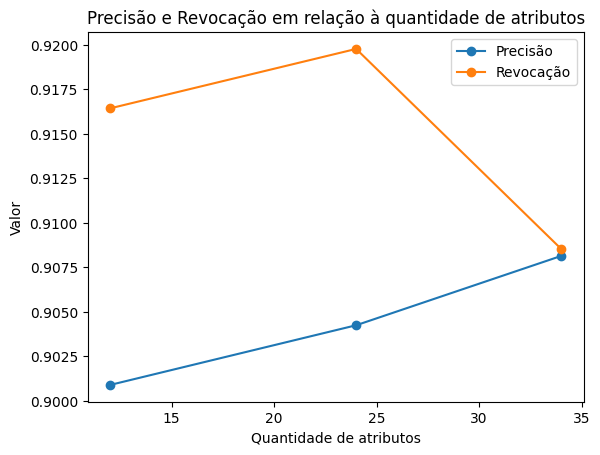

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support

precision = []
recall = []
num_attributes = []

# SB34
precision.append(prDTSB34[0][1])
recall.append(prDTSB34[1][1])
num_attributes.append(len(X_trainsSB34.columns))

# SB24
precision.append(prDTSB24[0][1])
recall.append(prDTSB24[1][1])
num_attributes.append(len(X_trainsSB24.columns))

# SB12
precision.append(prDTSB12[0][1])
recall.append(prDTSB12[1][1])
num_attributes.append(len(X_trainsSB12.columns))

plt.plot(num_attributes, precision, marker='o', label='Precisão')
plt.plot(num_attributes, recall, marker='o', label='Revocação')
plt.xlabel('Quantidade de atributos')
plt.ylabel('Valor')
plt.title('Precisão e Revocação em relação à quantidade de atributos')
plt.legend()
plt.show()

Resumo dos Testes com DecisionTree

In [ ]:
from  sklearn.metrics import classification_report

34 colunas

In [ ]:
cr = classification_report(y_test_categories, pred_lrDTSB34)

print(cr)

              precision    recall  f1-score   support

           0       0.73      0.73      0.73     16814
           1       0.91      0.91      0.91     50026

    accuracy                           0.86     66840
   macro avg       0.82      0.82      0.82     66840
weighted avg       0.86      0.86      0.86     66840



24 colunas

In [ ]:
cr = classification_report(y_test_categories, pred_lrDTSB24)

print(cr)

              precision    recall  f1-score   support

           0       0.75      0.71      0.73     16814
           1       0.90      0.92      0.91     50026

    accuracy                           0.87     66840
   macro avg       0.83      0.81      0.82     66840
weighted avg       0.87      0.87      0.87     66840



12 colunas

In [ ]:
cr = classification_report(y_test_categories, pred_lrDTSB12)

print(cr)

              precision    recall  f1-score   support

           0       0.74      0.70      0.72     16814
           1       0.90      0.92      0.91     50026

    accuracy                           0.86     66840
   macro avg       0.82      0.81      0.81     66840
weighted avg       0.86      0.86      0.86     66840



Holdout Repetitivo DecisionTree

In [ ]:
from sklearn.model_selection import train_test_split
import random
from sklearn import tree

34 colunas

In [ ]:
#gerar 10 números aleatórios entre 1 e 1000
list_random = random.sample(range(1, 1000), 10)

dtree = tree.DecisionTreeClassifier(random_state=88)

accs = []
for r in list_random:
  X_train, X_test, y_train, y_test = train_test_split(
      X_trainsSB34,
      y_train_categories,
      test_size = 0.3,
      stratify=y_train_categories,
      random_state=r
  )


  dtree = dtree.fit(X_train, y_train)
  y_predict = dtree.predict(X_test)
  acuracia = accuracy_score(y_test, y_predict)
  accs.append(acuracia)
print('Média: ', sum(accs)/len(accs))

Média:  0.8578994614003589


24 colunas

In [ ]:
#gerar 10 números aleatórios entre 1 e 1000
list_random = random.sample(range(1, 1000), 10)

dtree = tree.DecisionTreeClassifier(random_state=88)

accs = []
for r in list_random:
  X_train, X_test, y_train, y_test = train_test_split(
      X_trainsSB24,
      y_train_categories,
      test_size = 0.3,
      stratify=y_train_categories,
      random_state=r
  )


  dtree = dtree.fit(X_train, y_train)
  y_predict = dtree.predict(X_test)
  acuracia = accuracy_score(y_test, y_predict)
  accs.append(acuracia)
print('Média: ', sum(accs)/len(accs))

Média:  0.8643904419936735


12 colunas

In [ ]:
#gerar 10 números aleatórios entre 1 e 1000
list_random = random.sample(range(1, 1000), 10)

dtree = tree.DecisionTreeClassifier(random_state=88)

accs = []
for r in list_random:
  X_train, X_test, y_train, y_test = train_test_split(
      X_trainsSB24,
      y_train_categories,
      test_size = 0.3,
      stratify=y_train_categories,
      random_state=r
  )


  dtree = dtree.fit(X_train, y_train)
  y_predict = dtree.predict(X_test)
  acuracia = accuracy_score(y_test, y_predict)
  accs.append(acuracia)
print('Média: ', sum(accs)/len(accs))

Média:  0.8644673847995211


Cross-Validation DecisionTree

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn import tree

34 colunas

In [ ]:
dtree = tree.DecisionTreeClassifier(random_state=88)

# aplicar 10-fold cross validantios no modelo.
# cv recebe a quantidade de folds
y_predict = cross_val_predict(dtree, X_trainsSB34, y_train_categories, cv=10)

report = classification_report(y_train_categories, y_predict)

print(report)

              precision    recall  f1-score   support

           0       0.72      0.73      0.72     39232
           1       0.91      0.90      0.91    116725

    accuracy                           0.86    155957
   macro avg       0.81      0.82      0.81    155957
weighted avg       0.86      0.86      0.86    155957



24 colunas

In [ ]:
dtree = tree.DecisionTreeClassifier(random_state=88)

# aplicar 10-fold cross validantios no modelo.
# cv recebe a quantidade de folds
y_predict = cross_val_predict(dtree, X_trainsSB24, y_train_categories, cv=10)

report = classification_report(y_train_categories, y_predict)

print(report)

              precision    recall  f1-score   support

           0       0.75      0.70      0.72     39232
           1       0.90      0.92      0.91    116725

    accuracy                           0.87    155957
   macro avg       0.82      0.81      0.82    155957
weighted avg       0.86      0.87      0.86    155957



12 colunas

In [ ]:
dtree = tree.DecisionTreeClassifier(random_state=88)

# aplicar 10-fold cross validantios no modelo.
# cv recebe a quantidade de folds
y_predict = cross_val_predict(dtree, X_trainsSB12, y_train_categories, cv=10)

report = classification_report(y_train_categories, y_predict)

print(report)

              precision    recall  f1-score   support

           0       0.74      0.70      0.72     39232
           1       0.90      0.92      0.91    116725

    accuracy                           0.86    155957
   macro avg       0.82      0.81      0.81    155957
weighted avg       0.86      0.86      0.86    155957



Leave-one-Out DecisionTree

In [ ]:
from sklearn.model_selection import cross_val_predict, LeaveOneOut
from sklearn.metrics import classification_report
from sklearn import tree


34 colunas

In [ ]:
dtree = tree.DecisionTreeClassifier(random_state=88)

# aplicar 10-fold cross validantios no modelo.
# cv recebe a quantidade de folds
loo = LeaveOneOut()
y_predict = cross_val_predict(dtree, X_trainsSB34, y_train_categories, cv=loo.split(X_testSB34))

report = classification_report(y_train_categories, y_predict)

print(report)

24 colunas

In [ ]:
dtree = tree.DecisionTreeClassifier(random_state=88)

# aplicar 10-fold cross validantios no modelo.
# cv recebe a quantidade de folds
loo = LeaveOneOut()
y_predict = cross_val_predict(dtree, X_testSB24, y_test_categories, cv=loo.split(X_testSB24))

report = classification_report(y_test_categories, y_predict)

print(report)

12 colunas

In [ ]:
dtree = tree.DecisionTreeClassifier(random_state=88)

# aplicar 10-fold cross validantios no modelo.
# cv recebe a quantidade de folds
loo = LeaveOneOut()
y_predict = cross_val_predict(dtree, X_testSB12, y_test_categories, cv=loo.split(X_testSB12))

report = classification_report(y_test_categories, y_predict)

print(report)

## **MLPClassifier**

In [ ]:
from sklearn.neural_network import MLPClassifier

Acurácia

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
model_lr = MLPClassifier()
model_lr.fit(X_trainsSB34, y_train_categories)
pred_lrMLPSB34 = model_lr.predict(X_testSB34)

acc_lrMLPSB34 = accuracy_score(y_test_categories, pred_lrMLPSB34)

print("Acurácia MLPClassifier sb34:", acc_lrMLPSB34)

model_lr = MLPClassifier()
model_lr.fit(X_trainsSB24, y_train_categories)
pred_lrMLPSB24 = model_lr.predict(X_testSB24)

acc_lrMLPSB24 = accuracy_score(y_test_categories, pred_lrMLPSB24)

print("Acurácia MLPClassifier sb24:", acc_lrMLPSB24)

model_lr = MLPClassifier()
model_lr.fit(X_trainsSB12, y_train_categories)
pred_lrMLPSB12 = model_lr.predict(X_testSB12)

acc_lrMLPSB12 = accuracy_score(y_test_categories, pred_lrMLPSB12)

print("Acurácia MLPClassifier sb12:", acc_lrMLPSB12)

Acurácia MLPClassifier sb34: 0.8884051466187911
Acurácia MLPClassifier sb24: 0.8646918013165769
Acurácia MLPClassifier sb12: 0.8608767205266308


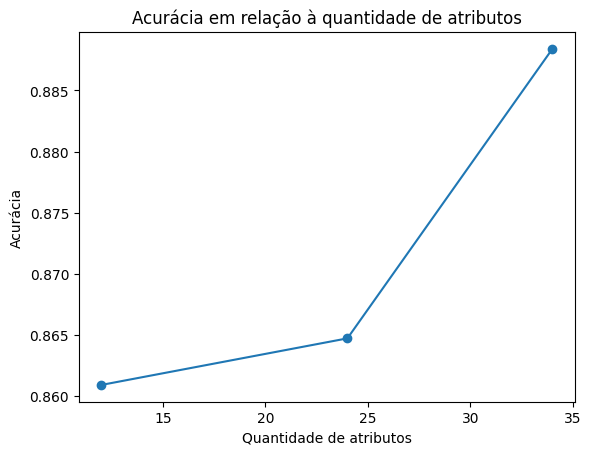

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score


metrics = []
num_attributes = []

metrics.append(acc_lrMLPSB34)
num_attributes.append(len(X_trainsSB34.columns))

metrics.append(acc_lrMLPSB24)
num_attributes.append(len(X_trainsSB24.columns))

metrics.append(acc_lrMLPSB12)
num_attributes.append(len(X_trainsSB12.columns))

plt.plot(num_attributes, metrics, marker='o')
plt.xlabel('Quantidade de atributos')
plt.ylabel('Acurácia')
plt.title('Acurácia em relação à quantidade de atributos')
plt.show()

Matriz de Confusão

In [ ]:
from  sklearn.metrics import confusion_matrix

34 colunas

In [ ]:
mc = confusion_matrix(y_test_categories, pred_lrMLPSB34)

# mostrar um DF
df_mc = pd.DataFrame(mc, columns=['Predito 0', 'Predito 1'], index=['Real 0', 'Real 1'])

df_mc

,Predito 0,Predito 1
Real 0,13453,3361
Real 1,4098,45928


24 colunas

In [ ]:
mc = confusion_matrix(y_test_categories, pred_lrMLPSB24)

# mostrar um DF
df_mc = pd.DataFrame(mc, columns=['Predito 0', 'Predito 1'], index=['Real 0', 'Real 1'])

df_mc

,Predito 0,Predito 1
Real 0,11370,5444
Real 1,3600,46426


12 colunas

In [ ]:
mc = confusion_matrix(y_test_categories, pred_lrMLPSB24)

# mostrar um DF
df_mc = pd.DataFrame(mc, columns=['Predito 0', 'Predito 1'], index=['Real 0', 'Real 1'])

df_mc

,Predito 0,Predito 1
Real 0,11370,5444
Real 1,3600,46426


Especificidade e Sensibilidade

In [ ]:
from  sklearn.metrics import recall_score

# sensibilidade = recall para a categoria 1
sMLPSB34 = recall_score(y_test_categories, pred_lrMLPSB34, pos_label=1)

# especificidade = recall para a categoria 0
eMLPSB34 = recall_score(y_test_categories, pred_lrMLPSB34, pos_label=0)

print("Sensibilidade SB34", sMLPSB34)
print("Especificidade SB34", eMLPSB34)

# sensibilidade = recall para a categoria 1
sMLPSB24 = recall_score(y_test_categories, pred_lrMLPSB24, pos_label=1)

# especificidade = recall para a categoria 0
eMLPSB24 = recall_score(y_test_categories, pred_lrMLPSB24, pos_label=0)

print("Sensibilidade SB24", sMLPSB24)
print("Especificidade SB24", eMLPSB24)

# sensibilidade = recall para a categoria 1
sMLPSB12 = recall_score(y_test_categories, pred_lrMLPSB12, pos_label=1)

# especificidade = recall para a categoria 0
eMLPSB12 = recall_score(y_test_categories, pred_lrMLPSB12, pos_label=0)

print("Sensibilidade SB12", sMLPSB12)
print("Especificidade SB12", eMLPSB12)

Sensibilidade SB34 0.9180825970495342
Especificidade SB34 0.8001070536457714
Sensibilidade SB24 0.9280374205413185
Especificidade SB24 0.6762221957892233
Sensibilidade SB12 0.9138248110982289
Especificidade SB12 0.7033424527179731


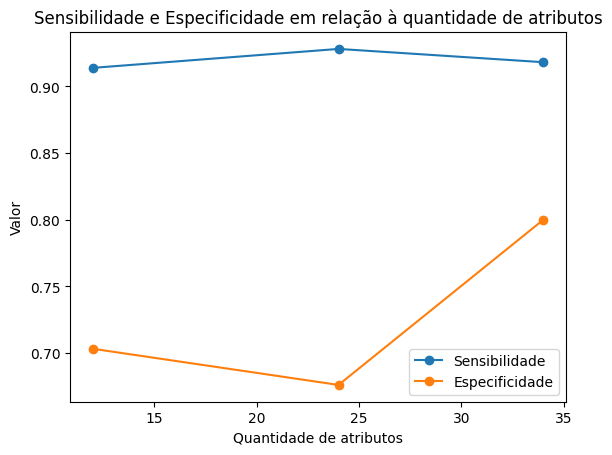

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score

sensitivity = []
specificity = []
num_attributes = []

# SB34
sensitivity.append(sMLPSB34)
specificity.append(eMLPSB34)
num_attributes.append(len(X_trainsSB34.columns))

# SB24
sensitivity.append(sMLPSB24)
specificity.append(eMLPSB24)
num_attributes.append(len(X_trainsSB24.columns))

# SB12
sensitivity.append(sMLPSB12)
specificity.append(eMLPSB12)
num_attributes.append(len(X_trainsSB12.columns))

plt.plot(num_attributes, sensitivity, marker='o', label='Sensibilidade')
plt.plot(num_attributes, specificity, marker='o', label='Especificidade')
plt.xlabel('Quantidade de atributos')
plt.ylabel('Valor')
plt.title('Sensibilidade e Especificidade em relação à quantidade de atributos')
plt.legend()
plt.show()

Precisão e Revocação

In [ ]:
from  sklearn.metrics import precision_recall_fscore_support
prMLPSB34 = precision_recall_fscore_support(y_test_categories, pred_lrMLPSB34)

print('Precisão SB34: ', prMLPSB34[0])
print('Revocação SB34: ', prMLPSB34[1])

prMLPSB24 = precision_recall_fscore_support(y_test_categories, pred_lrMLPSB24)

print('Precisão SB24: ', prMLPSB24[0])
print('Revocação SB24: ', prMLPSB24[1])

prMLPSB12 = precision_recall_fscore_support(y_test_categories, pred_lrMLPSB12)

print('Precisão SB12: ', prMLPSB12[0])
print('Revocação SB12: ', prMLPSB12[1])

Precisão SB34:  [0.76650903 0.93181034]
Revocação SB34:  [0.80010705 0.9180826 ]
Precisão SB24:  [0.75951904 0.89504531]
Revocação SB24:  [0.6762222  0.92803742]
Precisão SB12:  [0.73284997 0.90162318]
Revocação SB12:  [0.70334245 0.91382481]


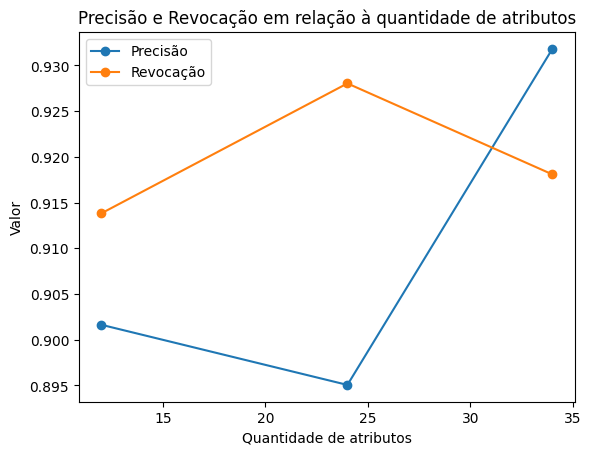

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support

precision = []
recall = []
num_attributes = []

# SB34
precision.append(prMLPSB34[0][1])
recall.append(prMLPSB34[1][1])
num_attributes.append(len(X_trainsSB34.columns))

# SB24
precision.append(prMLPSB24[0][1])
recall.append(prMLPSB24[1][1])
num_attributes.append(len(X_trainsSB24.columns))

# SB12
precision.append(prMLPSB12[0][1])
recall.append(prMLPSB12[1][1])
num_attributes.append(len(X_trainsSB12.columns))

plt.plot(num_attributes, precision, marker='o', label='Precisão')
plt.plot(num_attributes, recall, marker='o', label='Revocação')
plt.xlabel('Quantidade de atributos')
plt.ylabel('Valor')
plt.title('Precisão e Revocação em relação à quantidade de atributos')
plt.legend()
plt.show()

Resumo dos Testes com MLPClassifier


In [ ]:
from  sklearn.metrics import classification_report

34 colunas

In [ ]:
cr = classification_report(y_test_categories, pred_lrMLPSB34)

print(cr)

              precision    recall  f1-score   support

           0       0.77      0.80      0.78     16814
           1       0.93      0.92      0.92     50026

    accuracy                           0.89     66840
   macro avg       0.85      0.86      0.85     66840
weighted avg       0.89      0.89      0.89     66840



24 colunas

In [ ]:
cr = classification_report(y_test_categories, pred_lrMLPSB24)

print(cr)

              precision    recall  f1-score   support

           0       0.76      0.68      0.72     16814
           1       0.90      0.93      0.91     50026

    accuracy                           0.86     66840
   macro avg       0.83      0.80      0.81     66840
weighted avg       0.86      0.86      0.86     66840



12 colunas

In [ ]:
cr = classification_report(y_test_categories, pred_lrMLPSB12)

print(cr)

              precision    recall  f1-score   support

           0       0.73      0.70      0.72     16814
           1       0.90      0.91      0.91     50026

    accuracy                           0.86     66840
   macro avg       0.82      0.81      0.81     66840
weighted avg       0.86      0.86      0.86     66840



Holdout Repetitivo MLPClassifier

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import random

34 colunas

In [ ]:
#gerar 10 números aleatórios entre 1 e 1000
list_random = random.sample(range(1, 1000), 10)

mlp = MLPClassifier(random_state=88)

accs = []
for r in list_random:
  X_train, X_test, y_train, y_test = train_test_split(
      X_trainsSB34,
      y_train_categories,
      test_size = 0.3,
      stratify=y_train_categories,
      random_state=r
  )


  mlp = mlp.fit(X_train, y_train)
  y_predict = mlp.predict(X_test)
  acuracia = accuracy_score(y_test, y_predict)
  accs.append(acuracia)
print('Média: ', sum(accs)/len(accs))

Média:  0.884934171154997


24 colunas

In [ ]:
#gerar 10 números aleatórios entre 1 e 1000
list_random = random.sample(range(1, 1000), 10)

mlp = MLPClassifier(random_state=88)

accs = []
for r in list_random:
  X_train, X_test, y_train, y_test = train_test_split(
      X_trainsSB24,
      y_train_categories,
      test_size = 0.3,
      stratify=y_train_categories,
      random_state=r
  )


  mlp = mlp.fit(X_train, y_train)
  y_predict = mlp.predict(X_test)
  acuracia = accuracy_score(y_test, y_predict)
  accs.append(acuracia)
print('Média: ', sum(accs)/len(accs))

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Média:  0.8523788150807899


12 colunas

In [ ]:
#gerar 10 números aleatórios entre 1 e 1000
list_random = random.sample(range(1, 1000), 10)

mlp = MLPClassifier(random_state=88)

accs = []
for r in list_random:
  X_train, X_test, y_train, y_test = train_test_split(
      X_trainsSB12,
      y_train_categories,
      test_size = 0.3,
      stratify=y_train_categories,
      random_state=r
  )


  mlp = mlp.fit(X_train, y_train)
  y_predict = mlp.predict(X_test)
  acuracia = accuracy_score(y_test, y_predict)
  accs.append(acuracia)
print('Média: ', sum(accs)/len(accs))

Média:  0.8609415519648913


Cross-Validation MLPClassifier

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report

34 colunas

In [ ]:
mlp = MLPClassifier(random_state=88)

# aplicar 10-fold cross validantios no modelo.
# cv recebe a quantidade de folds
y_predict = cross_val_predict(mlp, X_trainsSB34, y_train_categories, cv=10)

report = classification_report(y_train_categories, y_predict)

print(report)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.78      0.76      0.77     16814
           1       0.92      0.93      0.92     50026

    accuracy                           0.89     66840
   macro avg       0.85      0.84      0.85     66840
weighted avg       0.89      0.89      0.89     66840



24 colunas

In [ ]:
mlp = MLPClassifier(random_state=88)

# aplicar 10-fold cross validantios no modelo.
# cv recebe a quantidade de folds
y_predict = cross_val_predict(mlp, X_trainsSB24, y_train_categories, cv=10)

report = classification_report(y_train_categories, y_predict)

print(report)

              precision    recall  f1-score   support

           0       0.75      0.70      0.72     16814
           1       0.90      0.92      0.91     50026

    accuracy                           0.86     66840
   macro avg       0.82      0.81      0.82     66840
weighted avg       0.86      0.86      0.86     66840



12 colunas

In [ ]:
mlp = MLPClassifier(random_state=88)

# aplicar 10-fold cross validantios no modelo.
# cv recebe a quantidade de folds
y_predict = cross_val_predict(mlp, X_trainsSB12, y_train_categories, cv=10)

report = classification_report(y_train_categories, y_predict)

print(report)

              precision    recall  f1-score   support

           0       0.75      0.68      0.71     16814
           1       0.90      0.92      0.91     50026

    accuracy                           0.86     66840
   macro avg       0.82      0.80      0.81     66840
weighted avg       0.86      0.86      0.86     66840



Leave-one-Out MLPClassifier

In [ ]:
from sklearn.model_selection import cross_val_predict, LeaveOneOut
from sklearn.metrics import classification_report
from sklearn import tree


34 colunas

In [ ]:
mlp = MLPClassifier(random_state=88)

# aplicar 10-fold cross validantios no modelo.
# cv recebe a quantidade de folds
loo = LeaveOneOut()
y_predict = cross_val_predict(mlp, X_trainsSB34, y_train_categories, cv=loo.split(X_trainsSB34))

report = classification_report(y_train_categories, y_predict)

print(report)

24 colunas

In [ ]:
mlp = MLPClassifier(random_state=88)

# aplicar 10-fold cross validantios no modelo.
# cv recebe a quantidade de folds
loo = LeaveOneOut()
y_predict = cross_val_predict(mlp, X_trainsSB24, y_train_categories, cv=loo.split(X_trainsSB24))

report = classification_report(y_train_categories, y_predict)

print(report)

12 colunas

In [ ]:
mlp = MLPClassifier(random_state=88)

# aplicar 10-fold cross validantios no modelo.
# cv recebe a quantidade de folds
loo = LeaveOneOut()
y_predict = cross_val_predict(mlp, X_trainsSB12, y_train_categories, cv=loo.split(X_trainSB12))

report = classification_report(y_train_categories, y_predict)

print(report)

## **GaussianNB**

In [ ]:
from sklearn.naive_bayes import GaussianNB

Acurácia

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
model_lr = GaussianNB()
model_lr.fit(X_trainsSB34, y_train_categories)
pred_lrGNBSB34 = model_lr.predict(X_testSB34)

acc_lrGNBSB34 = accuracy_score(y_test_categories, pred_lrGNBSB34)

print("Acurácia GaussianNB sb34:", acc_lrGNBSB34)

model_lr = GaussianNB()
model_lr.fit(X_trainsSB24, y_train_categories)
pred_lrGNBSB24 = model_lr.predict(X_testSB24)

acc_lrGNBSB24 = accuracy_score(y_test_categories, pred_lrGNBSB24)

print("Acurácia GaussianNB sb24:", acc_lrGNBSB24)

model_lr = GaussianNB()
model_lr.fit(X_trainsSB12, y_train_categories)
pred_lrGNBSB12 = model_lr.predict(X_testSB12)

acc_lrGNBSB12 = accuracy_score(y_test_categories, pred_lrGNBSB12)

print("Acurácia GaussianNB sb12:", acc_lrGNBSB12)

Acurácia GaussianNB sb34: 0.7301765409934171
Acurácia GaussianNB sb24: 0.7466187911430281
Acurácia GaussianNB sb12: 0.8096349491322561


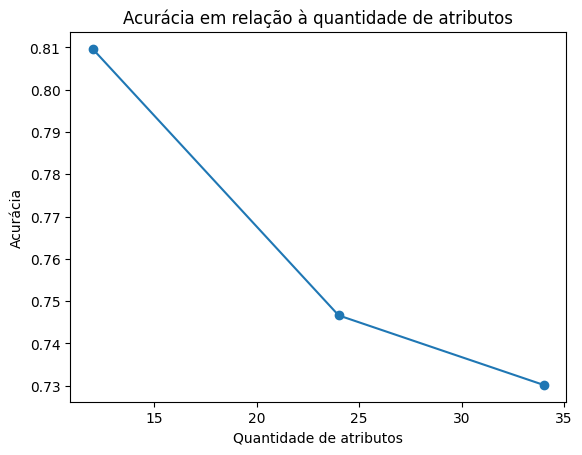

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score


metrics = []
num_attributes = []

metrics.append(acc_lrGNBSB34)
num_attributes.append(len(X_trainsSB34.columns))

metrics.append(acc_lrGNBSB24)
num_attributes.append(len(X_trainsSB24.columns))

metrics.append(acc_lrGNBSB12)
num_attributes.append(len(X_trainsSB12.columns))

plt.plot(num_attributes, metrics, marker='o')
plt.xlabel('Quantidade de atributos')
plt.ylabel('Acurácia')
plt.title('Acurácia em relação à quantidade de atributos')
plt.show()

Matriz de Confusão

In [ ]:
from  sklearn.metrics import confusion_matrix

34 colunas

In [ ]:
mc = confusion_matrix(y_test_categories, pred_lrGNBSB34)

# mostrar um DF
df_mc = pd.DataFrame(mc, columns=['Predito 0', 'Predito 1'], index=['Real 0', 'Real 1'])

df_mc

,Predito 0,Predito 1
Real 0,14287,2527
Real 1,15508,34518


24 colunas

In [ ]:
mc = confusion_matrix(y_test_categories, pred_lrGNBSB24)

# mostrar um DF
df_mc = pd.DataFrame(mc, columns=['Predito 0', 'Predito 1'], index=['Real 0', 'Real 1'])

df_mc

,Predito 0,Predito 1
Real 0,13482,3332
Real 1,13604,36422


12 colunas

In [ ]:
mc = confusion_matrix(y_test_categories, pred_lrGNBSB12)

# mostrar um DF
df_mc = pd.DataFrame(mc, columns=['Predito 0', 'Predito 1'], index=['Real 0', 'Real 1'])

df_mc

,Predito 0,Predito 1
Real 0,9236,7578
Real 1,5146,44880


Especificidade e Sensibilidade

In [ ]:
from  sklearn.metrics import recall_score

# sensibilidade = recall para a categoria 1
sGNBSB34 = recall_score(y_test_categories, pred_lrGNBSB34, pos_label=1)

# especificidade = recall para a categoria 0
eGNBSB34 = recall_score(y_test_categories, pred_lrGNBSB34, pos_label=0)

print("Sensibilidade SB34", sGNBSB34)
print("Especificidade SB34", eGNBSB34)

# sensibilidade = recall para a categoria 1
sGNBSB24 = recall_score(y_test_categories, pred_lrGNBSB24, pos_label=1)

# especificidade = recall para a categoria 0
eGNBSB24 = recall_score(y_test_categories, pred_lrGNBSB24, pos_label=0)

print("Sensibilidade SB24", sGNBSB24)
print("Especificidade SB24", eGNBSB24)

# sensibilidade = recall para a categoria 1
sGNBSB12 = recall_score(y_test_categories, pred_lrGNBSB12, pos_label=1)

# especificidade = recall para a categoria 0
eGNBSB12 = recall_score(y_test_categories, pred_lrGNBSB12, pos_label=0)

print("Sensibilidade SB12", sGNBSB12)
print("Especificidade SB12", eGNBSB12)

Sensibilidade SB34 0.6900011993763243
Especificidade SB34 0.8497085761865112
Sensibilidade SB24 0.7280614080678047
Especificidade SB24 0.8018318068276437
Sensibilidade SB12 0.8971334905848959
Especificidade SB12 0.549304151302486


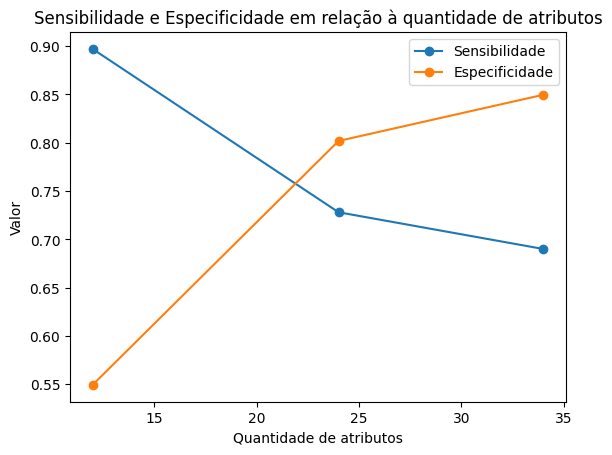

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score

sensitivity = []
specificity = []
num_attributes = []

# SB34
sensitivity.append(sGNBSB34)
specificity.append(eGNBSB34)
num_attributes.append(len(X_trainsSB34.columns))

# SB24
sensitivity.append(sGNBSB24)
specificity.append(eGNBSB24)
num_attributes.append(len(X_trainsSB24.columns))

# SB12
sensitivity.append(sGNBSB12)
specificity.append(eGNBSB12)
num_attributes.append(len(X_trainsSB12.columns))

plt.plot(num_attributes, sensitivity, marker='o', label='Sensibilidade')
plt.plot(num_attributes, specificity, marker='o', label='Especificidade')
plt.xlabel('Quantidade de atributos')
plt.ylabel('Valor')
plt.title('Sensibilidade e Especificidade em relação à quantidade de atributos')
plt.legend()
plt.show()

Precisão e Revocação

In [ ]:
from  sklearn.metrics import precision_recall_fscore_support
prGNBSB34 = precision_recall_fscore_support(y_test_categories, pred_lrGNBSB34)

print('Precisão SB34: ', prGNBSB34[0])
print('Revocação SB34: ', prGNBSB34[1])

prGNBSB24 = precision_recall_fscore_support(y_test_categories, pred_lrGNBSB24)

print('Precisão SB24: ', prGNBSB24[0])
print('Revocação SB24: ', prGNBSB24[1])

prGNBSB12 = precision_recall_fscore_support(y_test_categories, pred_lrGNBSB12)

print('Precisão SB12: ', prGNBSB12[0])
print('Revocação SB12: ', prGNBSB12[1])

Precisão SB34:  [0.47950998 0.93178567]
Revocação SB34:  [0.84970858 0.6900012 ]
Precisão SB24:  [0.49774791 0.91618453]
Revocação SB24:  [0.80183181 0.72806141]
Precisão SB12:  [0.64219163 0.85554158]
Revocação SB12:  [0.54930415 0.89713349]


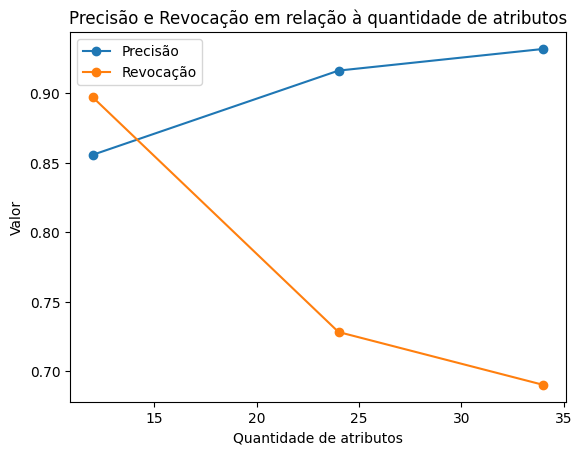

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support

precision = []
recall = []
num_attributes = []

# SB34
precision.append(prGNBSB34[0][1])
recall.append(prGNBSB34[1][1])
num_attributes.append(len(X_trainsSB34.columns))

# SB24
precision.append(prGNBSB24[0][1])
recall.append(prGNBSB24[1][1])
num_attributes.append(len(X_trainsSB24.columns))

# SB12
precision.append(prGNBSB12[0][1])
recall.append(prGNBSB12[1][1])
num_attributes.append(len(X_trainsSB12.columns))

plt.plot(num_attributes, precision, marker='o', label='Precisão')
plt.plot(num_attributes, recall, marker='o', label='Revocação')
plt.xlabel('Quantidade de atributos')
plt.ylabel('Valor')
plt.title('Precisão e Revocação em relação à quantidade de atributos')
plt.legend()
plt.show()

Resumo dos Testes com GaussianNB

In [ ]:
from  sklearn.metrics import classification_report

34 colunas

In [ ]:
cr = classification_report(y_test_categories, pred_lrGNBSB34)

print(cr)

              precision    recall  f1-score   support

           0       0.48      0.85      0.61     16814
           1       0.93      0.69      0.79     50026

    accuracy                           0.73     66840
   macro avg       0.71      0.77      0.70     66840
weighted avg       0.82      0.73      0.75     66840



24 colunas

In [ ]:
cr = classification_report(y_test_categories, pred_lrGNBSB24)

print(cr)

              precision    recall  f1-score   support

           0       0.50      0.80      0.61     16814
           1       0.92      0.73      0.81     50026

    accuracy                           0.75     66840
   macro avg       0.71      0.76      0.71     66840
weighted avg       0.81      0.75      0.76     66840



12 colunas

In [ ]:
cr = classification_report(y_test_categories, pred_lrGNBSB12)

print(cr)

              precision    recall  f1-score   support

           0       0.64      0.55      0.59     16814
           1       0.86      0.90      0.88     50026

    accuracy                           0.81     66840
   macro avg       0.75      0.72      0.73     66840
weighted avg       0.80      0.81      0.80     66840



Holdout Repetitivo MLPClassifier

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import random

34 colunas

In [ ]:
#gerar 10 números aleatórios entre 1 e 1000
list_random = random.sample(range(1, 1000), 10)

gnb = GaussianNB()

accs = []
for r in list_random:
  X_train, X_test, y_train, y_test = train_test_split(
      X_trainsSB34,
      y_train_categories,
      test_size = 0.3,
      stratify=y_train_categories,
      random_state=r
  )


  gnb = gnb.fit(X_train, y_train)
  y_predict = gnb.predict(X_test)
  acuracia = accuracy_score(y_test, y_predict)
  accs.append(acuracia)
print('Média: ', sum(accs)/len(accs))

Média:  0.7353131857171353


24 colunas

In [ ]:
#gerar 10 números aleatórios entre 1 e 1000
list_random = random.sample(range(1, 1000), 10)

gnb = GaussianNB()

accs = []
for r in list_random:
  X_train, X_test, y_train, y_test = train_test_split(
      X_trainsSB24,
      y_train_categories,
      test_size = 0.3,
      stratify=y_train_categories,
      random_state=r
  )


  gnb = gnb.fit(X_train, y_train)
  y_predict = gnb.predict(X_test)
  acuracia = accuracy_score(y_test, y_predict)
  accs.append(acuracia)
print('Média: ', sum(accs)/len(accs))

Média:  0.750029922202274


12 colunas

In [ ]:
#gerar 10 números aleatórios entre 1 e 1000
list_random = random.sample(range(1, 1000), 10)

gnb = GaussianNB()

accs = []
for r in list_random:
  X_train, X_test, y_train, y_test = train_test_split(
      X_trainsSB12,
      y_train_categories,
      test_size = 0.3,
      stratify=y_train_categories,
      random_state=r
  )


  gnb = gnb.fit(X_train, y_train)
  y_predict = gnb.predict(X_test)
  acuracia = accuracy_score(y_test, y_predict)
  accs.append(acuracia)
print('Média: ', sum(accs)/len(accs))

Média:  0.8090315180530621


Cross-Validation MLPClassifier

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report

34 colunas

In [ ]:
gnb = GaussianNB()

# aplicar 10-fold cross validantios no modelo.
# cv recebe a quantidade de folds
y_predict = cross_val_predict(gnb, X_trainsSB34, y_train_categories, cv=10)

report = classification_report(y_train_categories, y_predict)

print(report)

              precision    recall  f1-score   support

           0       0.48      0.85      0.62     16814
           1       0.93      0.70      0.80     50026

    accuracy                           0.73     66840
   macro avg       0.71      0.77      0.71     66840
weighted avg       0.82      0.73      0.75     66840



24 colunas

In [ ]:
gnb = GaussianNB()

# aplicar 10-fold cross validantios no modelo.
# cv recebe a quantidade de folds
y_predict = cross_val_predict(gnb, X_trainsSB24, y_train_categories, cv=10)

report = classification_report(y_train_categories, y_predict)

print(report)

              precision    recall  f1-score   support

           0       0.50      0.76      0.60     16814
           1       0.90      0.75      0.82     50026

    accuracy                           0.75     66840
   macro avg       0.70      0.75      0.71     66840
weighted avg       0.80      0.75      0.76     66840



12 colunas

In [ ]:
gnb = GaussianNB()

# aplicar 10-fold cross validantios no modelo.
# cv recebe a quantidade de folds
y_predict = cross_val_predict(gnb, X_trainsSB12, y_train_categories, cv=10)

report = classification_report(y_train_categories, y_predict)

print(report)

              precision    recall  f1-score   support

           0       0.64      0.55      0.59     16814
           1       0.86      0.90      0.88     50026

    accuracy                           0.81     66840
   macro avg       0.75      0.72      0.73     66840
weighted avg       0.80      0.81      0.80     66840



Leave-one-Out MLPClassifier

In [ ]:
from sklearn.model_selection import cross_val_predict, LeaveOneOut
from sklearn.metrics import classification_report
from sklearn import tree


34 colunas

In [ ]:
gnb = GaussianNB()

# aplicar 10-fold cross validantios no modelo.
# cv recebe a quantidade de folds
loo = LeaveOneOut()
y_predict = cross_val_predict(gnb, X_trainsSB34, y_train_categories, cv=loo.split(X_trainsSB34))

report = classification_report(y_train_categories, y_predict)

print(report)

24 colunas

In [ ]:
gnb = GaussianNB()

# aplicar 10-fold cross validantios no modelo.
# cv recebe a quantidade de folds
loo = LeaveOneOut()
y_predict = cross_val_predict(gnb, X_trainsSB24, y_train_categories, cv=loo.split(X_trainsSB24))

report = classification_report(y_train_categories, y_predict)

print(report)

12 colunas

In [ ]:
gnb = GaussianNB()

# aplicar 10-fold cross validantios no modelo.
# cv recebe a quantidade de folds
loo = LeaveOneOut()
y_predict = cross_val_predict(gnb, X_trainsSB12, y_train_categories, cv=loo.split(X_trainsSB12))

report = classification_report(y_train_categories, y_predict)

print(report)

## GridSeachCV

DecisionTree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

params = {
    'criterion':('gini', 'entropy', 'log_loss'),
    'max_depth':[3, 5, 7, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
cvAr = [5, 10, 15]
scoringAr = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
best_rank = float('inf')

for i in cvAr:
  for j in scoringAr:
    rf = DecisionTreeClassifier(random_state=88)
    gs = GridSearchCV(rf, params, cv=i, scoring=j)
    gs.fit(X_trainsSB24, y_train_categories)

    result = pd.DataFrame(gs.cv_results_)
    sorted_result = result[['params','rank_test_score','mean_test_score']].sort_values('rank_test_score')

best_params = sorted_result.loc[sorted_result['rank_test_score'] == 1, 'params'].iloc[0]
best_mean_score = sorted_result.loc[sorted_result['rank_test_score'] == 1, 'mean_test_score'].iloc[0]

print('Melhores hiperparâmetros para DecisionTreeClassifier (cv={}, scoring={}):'.format(i, j))
print('  Rank:', 1)
print('  Média do Test Score:', best_mean_score)
print('  Hiperparâmetros:', best_params)

Melhores hiperparâmetros para DecisionTreeClassifier (cv=15, scoring=roc_auc):
  Rank: 1
  Média do Test Score: 0.921952705846922
  Hiperparâmetros: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10}


MLPClassifier


In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

params = {
    'activation': ('identity', 'logistic', 'tanh', 'relu'),
    'solver': ('lbfgs', 'sgd', 'adam'),
    'learning_rate': ('constant', 'invscaling', 'adaptive'),
}

cvAr = [5, 10, 15]
scoringAr = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
best_rank = float('inf')
x_train1 = X_trainsSB34.head(10000)
y_train = y_train_categories.head(10000)
n = 0
for i in cvAr:
  for j in scoringAr:
    rf = MLPClassifier(random_state=88)
    gs = GridSearchCV(rf, params, cv=i, scoring=j)
    gs.fit(x_train1, y_train)

    n += 1
    print('########################{}###########################'.format(n))
    result = pd.DataFrame(gs.cv_results_)
    sorted_result = result[['params','rank_test_score','mean_test_score']].sort_values('rank_test_score')

best_params = sorted_result.loc[sorted_result['rank_test_score'] == 1, 'params'].iloc[0]
best_mean_score = sorted_result.loc[sorted_result['rank_test_score'] == 1, 'mean_test_score'].iloc[0]

print('Melhores hiperparâmetros para MLPClassifier (cv={}, scoring={}):'.format(i, j))
print('  Rank:', 1)
print('  Média do Test Score:', best_mean_score)
print('  Hiperparâmetros:', best_params)


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)

KeyboardInterrupt



In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
best_params = {'activation': 'relu', 'learning_rate': 'constant', 'solver': 'adam'}
model_lr = MLPClassifier(**best_params)
model_lr.fit(X_trainsSB34, y_train_categories)
pred_lrDTSB34 = model_lr.predict(X_testSB34)

acc_lrDTSB34 = accuracy_score(y_test_categories, pred_lrDTSB34)

print("Acurácia MLPClassifier sb34:", acc_lrDTSB34)

Acurácia MLPClassifier sb24: 0.8887642130460802


GaussianNB

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV

params = {
    'priors': [None, [0.2, 0.8], [0.5, 0.5]]
}

cvAr = [5, 10, 15]
scoringAr = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
best_rank = float('inf')

best_i = None
best_j = None

for i in cvAr:
  for j in scoringAr:
    rf = GaussianNB()
    gs = GridSearchCV(rf, params, cv=i, scoring=j)
    gs.fit(X_trainsSB12, y_train_categories)

    result = pd.DataFrame(gs.cv_results_)
    sorted_result = result[['params','rank_test_score','mean_test_score']].sort_values('rank_test_score')

best_params = sorted_result.loc[sorted_result['rank_test_score'] == 1, 'params'].iloc[0]
best_mean_score = sorted_result.loc[sorted_result['rank_test_score'] == 1, 'mean_test_score'].iloc[0]

print('Melhores hiperparâmetros para DecisionTreeClassifier (cv={}, scoring={}):'.format(best_i, best_j))
print('  Rank:', 1)
print('  Média do Test Score:', best_mean_score)
print('  Hiperparâmetros:', best_params)

Melhores hiperparâmetros para DecisionTreeClassifier (cv=15, scoring=roc_auc):
  Rank: 1
  Média do Test Score: 0.8614761895003685
  Hiperparâmetros: {'priors': None}


In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
best_params = {'priors': None}
model_lr = GaussianNB(**best_params)
model_lr.fit(X_trainsSB12, y_train_categories)
pred_lrDTSB12 = model_lr.predict(X_testSB12)

acc_lrDTSB12 = accuracy_score(y_test_categories, pred_lrDTSB12)

print("Acurácia GaussianNB sb12:", acc_lrDTSB12)

Acurácia GaussianNB sb12: 0.8096349491322561
